## Text Detector

In [3]:
import math
import cv2
import re
import PIL
import html
import textwrap
from unet import *
import numpy as np
from data import *
from PIL import Image
import skimage.io as io
from imageio import imread
import matplotlib.pyplot as plt
import skimage.transform as trans
from multiprocessing import Pool
import skimage.transform as trans
import xml.etree.ElementTree as ET
from keras.preprocessing import image

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as K
from keras.optimizers import Adam, SGD
from PIL import Image, ImageFont, ImageDraw
# from keras.models import load_model
import numpy as np
import pytesseract
from math import ceil
from matplotlib import pyplot as plt
from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from keras_layers.keras_layer_L2Normalization import L2Normalization
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
# from data_generator.object_detection_2d_data_generator_manga import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

## 1. Setup
### 1.1 parpameters

In [4]:
img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 32, 64, 100] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

### 1.2 Load a previously created model

In [7]:
%%time
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'checkpoint/ssd300_all.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=0.8)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'compute_loss': ssd_loss.compute_loss})

model2 = unet()
model2.load_weights("checkpoint/unet_8.hdf5")

/Users/panziqi/Desktop/Mlator/to_wtq/unet.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


CPU times: user 4.52 s, sys: 459 ms, total: 4.97 s
Wall time: 3.28 s


In [8]:
%%time
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'checkpoint/ssd300_all.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=0.8)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'compute_loss': ssd_loss.compute_loss})

model2 = unet()
model2.load_weights("checkpoint/unet_8.hdf5")

/Users/panziqi/Desktop/Mlator/to_wtq/unet.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


CPU times: user 4.58 s, sys: 508 ms, total: 5.09 s
Wall time: 3.35 s


## 2. Make predictions

You can set the `shuffle` option to `False` if you would like to check the model's progress on the same image(s) over the course of the training.

In [106]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.
# We'll only load one image in this example.
#27
img_path = 'upload/152.jpg'
# img_load = imread(img_path)
img_load = Image.open(img_path).convert("RGB")
    
orig_images.append(np.array(img_load))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

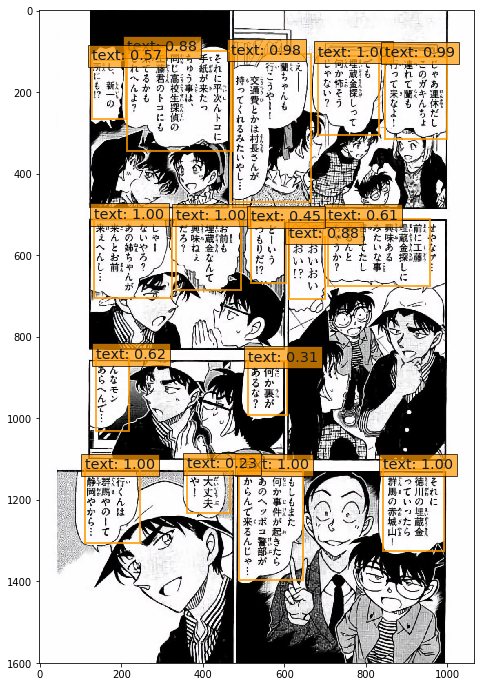

In [107]:
# 1: Set the generator for the predictions.
batch_original_images = orig_images
batch_images = input_images
# i = 0 # Which batch item to look at

# 2: Make predictions.
y_pred = model.predict(input_images)

# 3: Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.17,
                                   iou_threshold=0.01,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

# 4: Convert the predictions for the original image + manual offset.
# decode
y_pred_decoded_inv = y_pred_decoded.copy()
y_pred_decoded_inv[0][:,2] = y_pred_decoded[0][:,2]* orig_images[0].shape[1] / img_width-3
y_pred_decoded_inv[0][:,3] = y_pred_decoded[0][:,3]* orig_images[0].shape[0] / img_height-3
y_pred_decoded_inv[0][:,4] = y_pred_decoded[0][:,4]* orig_images[0].shape[1] / img_width+28
y_pred_decoded_inv[0][:,5] = y_pred_decoded[0][:,5]* orig_images[0].shape[0] / img_height+28


np.set_printoptions(precision=2, suppress=True, linewidth=90)
i = 0
# 5: Draw the predicted boxes onto the image
# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background','text']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[i])

current_axis = plt.gca()

for box in y_pred_decoded_inv[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color="#FF9900", fill=False, linewidth=2,alpha=0.8))  
    current_axis.text(xmin, ymin, label, size='x-large', color='#131A22', bbox={'facecolor':"#FF9900", 'alpha':0.7})    
    
# output text_box in this script
text_box = []
for y_pred_decode in y_pred_decoded_inv:
    text_box.append(y_pred_decode[:,2:].astype(np.int32))

In [108]:
w,h = img_load.size
h/w

1.5009380863039399

## OCR+Translate

In [109]:
# Imports the Google Cloud client library
from google.cloud import translate
import six
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="nmt-API-07b7802bb743.json"
# /Users/panziqi/Desktop/Mlator/ssd_keras/nmt-API-07b7802bb743.json
translate_client = translate.Client()
target = 'en'

In [110]:
class TransGT(object):
    def __init__(self, text, source_language ='ja'):
        self.text = text
        self.source_language = source_language
    def translator(self):
        translated = translate_client.translate(
            self.text,
            source_language = self.source_language,
            model=translate.NMT,
            format_='text'
            )
        result = []
        for tran in translated:
            result.append(tran['translatedText'])
        return result

In [111]:
def crop_words(img, boxes):
    """
    make sure that the vertices of all boxes are inside the image
    """
    words = []
    for j in range(len(boxes)):
        h, w = img.shape[:2]
        if boxes.shape[1] == 4:
            # box case
            box = boxes[j]
            xmin, ymin, xmax, ymax = box
            if xmin==xmax:
                xmax+=5
            if ymin==ymax:
                ymax+=5
            
            word_w, word_h = xmax - xmin, ymax - ymin
            word_ar = word_w / word_h
            word = img[ymin:ymax,xmin:xmax,:]
        words.append(word)
    return words

In [112]:
xmin, ymin, xmax, ymax = text_box[0][0]
image_patch = batch_original_images[0][ymin:ymax,xmin:xmax,:]
bg_color = np.quantile(image_patch[np.where(image_patch>220)],0.3)

## Create Mask

(1600, 1066)


/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


CPU times: user 4.89 s, sys: 1.76 s, total: 6.64 s
Wall time: 935 ms


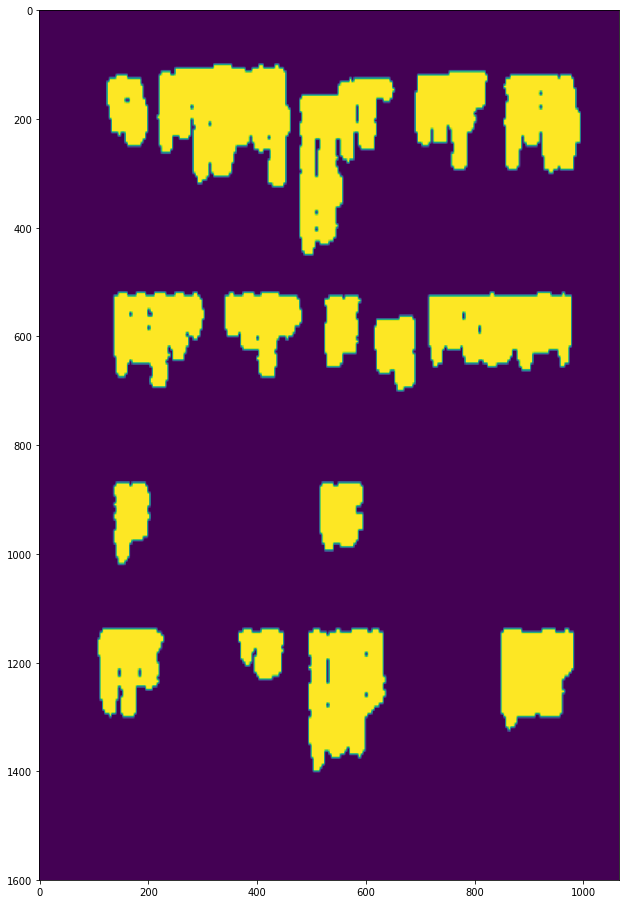

In [113]:
%%time
img_L = img_load.convert("L")
img_array = np.array(img_L)
sh = img_array.shape
print(sh)
img_rz = trans.resize(img_array,(256,256,1))
img_rz = np.expand_dims(img_rz,axis=0)
pred = model2.predict(img_rz)>0.2
mask = trans.resize(pred[0][:,:,0],sh)

plt.figure(figsize=(16, 16))
plt.imshow(mask)

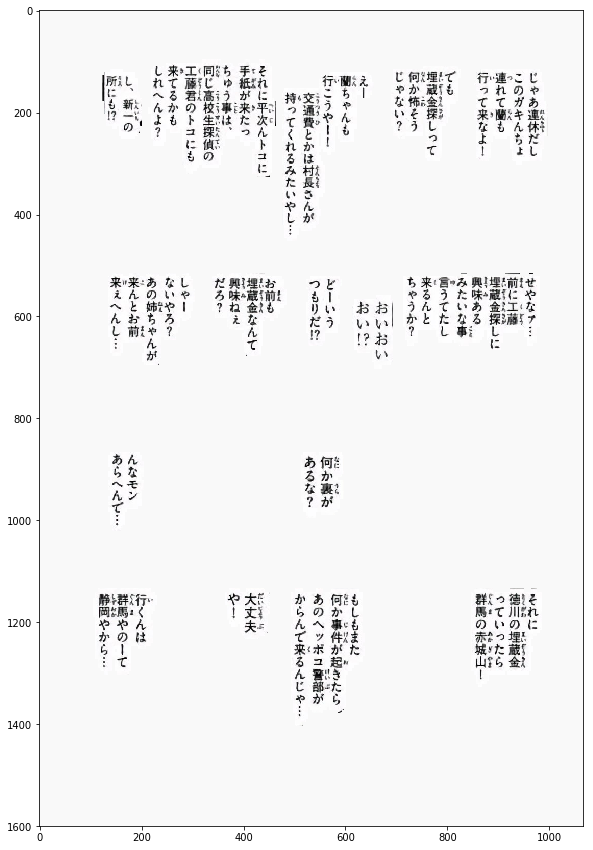

In [114]:
img_seg = np.array(img_load)
img_seg[mask==0]=bg_color

plt.figure(figsize=(15,15))
plt.imshow(img_seg)

In [115]:
import time

In [116]:
%%time
text_ocr = []
crop_page = []
ocr_page = []
ocr_page_tran = []
text_ocr_tran = []
text_box_clean = []

r = re.compile(r'[-A-Za-z1-9(){}\[\]\【】/|~《》』\\<ぇー_]+')
r2 = re.compile(r'[二p:"=]+')

def ocr(image):
#     ret,image = cv2.threshold(image,117,250,cv2.THRESH_BINARY)
    t = pytesseract.image_to_string(image, lang='jpn_vbest',config="--psm 12 --oem 1")
    t = r.sub(' ',t).split()
    t = "".join(t)
    t = r2.sub('!!',t)
    return t

start = time.time()

cropped = crop_words(img_seg,text_box[0])

end = time.time()
print(start-end)

start = time.time()

cropped_filter = []
mask_text = []
for j in range(len(cropped)):
    h,w,_ = cropped[j].shape
#     if h<w/1.5:
#         continue
    cropped_filter.append(cropped[j])
    mask_text.append(j)

end = time.time()
print(start-end)

start = time.time()

text_box_clean.append(text_box[0][mask_text])

pool1=Pool(12)
text_ocr = pool1.map(ocr, cropped_filter)
pool1.close()
pool1.join()
end = time.time()
print(start-end)

start = time.time()

eng = TransGT(text_ocr)
text_ocr_tran = eng.translator()

end = time.time()
print(start-end)

crop_page.append(cropped_filter)
ocr_page.append(np.array(text_ocr))
ocr_page_tran.append(np.array(text_ocr_tran))

-6.198883056640625e-05
-6.508827209472656e-05
-4.889739990234375
-1.1586430072784424
CPU times: user 94.8 ms, sys: 80.6 ms, total: 175 ms
Wall time: 6.05 s


In [117]:
ocr_page

[array(['もしもまたに何か事件が起きたらっあのへッポコ罰部がからんで来るんじゃ!!', 'でもうペダ埋蔵金探しってらぶ何か怖そうじゃない?',
        '行んはし群馬やの静岡やから', 'しゃないやろ?あの姉ちゃんが来んとお前来ミへんし…', 'それにかい徳川の埋蔵金でっていったら君馬の赤城山',
        'お前もいす埋蔵金なんて興味ねだろ?', 'じゃあぁ連休だしこのガキんちょ連れて陳も行って来なよ!',
        'ええ曽ちゃんも行こうやっ交通費とかは村長さんが持ってくれるみたいやし',
        'るそれに平次んトコビ手紙が来たっちゅう事は、和同じ高校生探偵のいてと工藤君のトコにも来てるかもしれへんよ?', 'おごらめおっ', 'んなモンあらへんで…',
        '人をとてうに工林前まい和信きダ埋蔵金探しに興味あるみたいな事店うてた来るんとちゃうか?', 'し、新一の所にも', 'どいうつもりだ', '何か裏があるな?',
        'お>マム'], dtype='<U53')]

In [118]:
ocr_page_tran

[array(['If something happens again, then the Heppoko punishment club will be entertained !!',
        "So I'm already scared of looking for Peda buried money?",
        'Goshinashi Gunma and Shizuoka or from',
        'If that elder sister is coming, then he will come to the fore ...',
        "If it's buried in Tokugawa, it is Akagiyama of your horse",
        'You are interested in the buried deposit?',
        "Well then it's a long holiday, and I'm going to take Chen with me again!",
        "Yes, let's go and see if the village head will bring transportation expenses.",
        "In addition to that, when it comes to Tokobi letters, there may be a high school student detective who is the same as a Japanese high school detective and Kudo's toko.",
        'Thank you', 'Hmmm.',
        'I wonder if people will come to the store to find out if they are interested in searching for a sum of money in Kobayashi before Urin.',
        'Also in the place of Shinichi', 'I mean', 'Is there a

1 でもうペダ埋蔵金探しってらぶ何か怖そうじゃない?
1 So I'm already scared of looking for Peda buried money?


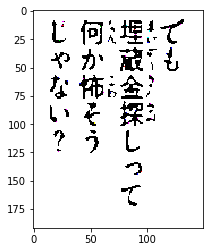

2 行んはし群馬やの静岡やから
2 Goshinashi Gunma and Shizuoka or from


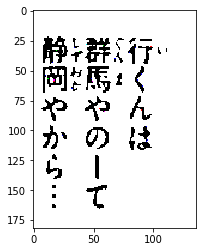

3 しゃないやろ?あの姉ちゃんが来んとお前来ミへんし…
3 If that elder sister is coming, then he will come to the fore ...


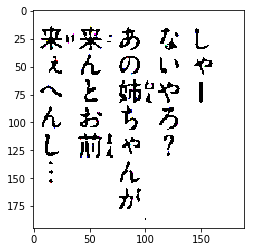

4 それにかい徳川の埋蔵金でっていったら君馬の赤城山
4 If it's buried in Tokugawa, it is Akagiyama of your horse


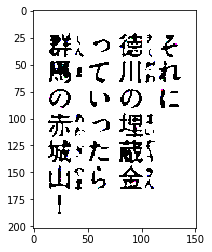

5 お前もいす埋蔵金なんて興味ねだろ?
5 You are interested in the buried deposit?


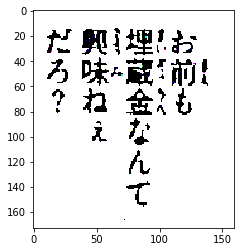

6 じゃあぁ連休だしこのガキんちょ連れて陳も行って来なよ!
6 Well then it's a long holiday, and I'm going to take Chen with me again!


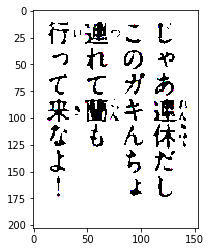

7 ええ曽ちゃんも行こうやっ交通費とかは村長さんが持ってくれるみたいやし
7 Yes, let's go and see if the village head will bring transportation expenses.


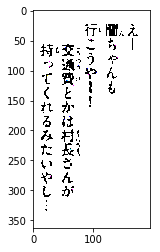

8 るそれに平次んトコビ手紙が来たっちゅう事は、和同じ高校生探偵のいてと工藤君のトコにも来てるかもしれへんよ?
8 In addition to that, when it comes to Tokobi letters, there may be a high school student detective who is the same as a Japanese high school detective and Kudo's toko.


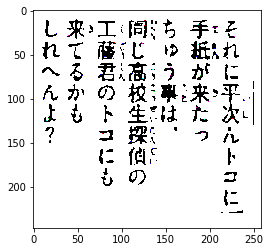

9 おごらめおっ
9 Thank you


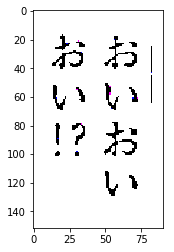

10 んなモンあらへんで…
10 Hmmm.


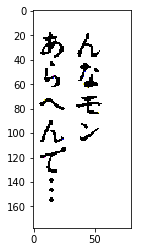

11 人をとてうに工林前まい和信きダ埋蔵金探しに興味あるみたいな事店うてた来るんとちゃうか?
11 I wonder if people will come to the store to find out if they are interested in searching for a sum of money in Kobayashi before Urin.


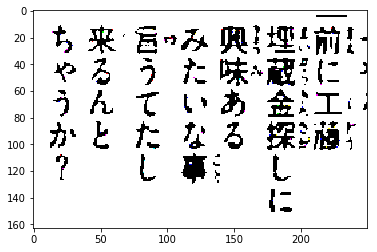

12 し、新一の所にも
12 Also in the place of Shinichi


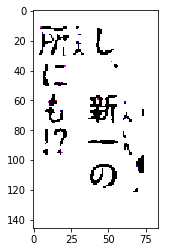

13 どいうつもりだ
13 I mean


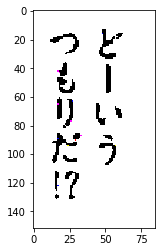

14 何か裏があるな?
14 Is there anything wrong?


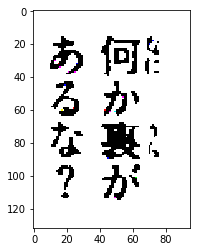

15 お>マム
15 Oh> Mamu


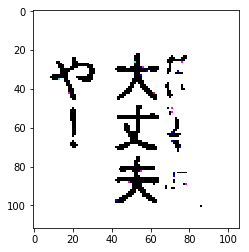

In [119]:
w=10
h=10
# fig=plt.figure(figsize=(10, 10))
length = len(crop_page[0])
cols = 5
rows = int(np.ceil(length/cols))
for i in range(1, cols*rows +1):
    if i>length-1:
        break
#     fig.add_subplot(rows, cols, i)
    plt.imshow(crop_page[0][i])
    plt.imshow(cv2.threshold(crop_page[0][i],115,255,cv2.THRESH_BINARY)[1])
    print("{}".format(i),ocr_page[0][i])
    print("{}".format(i),ocr_page_tran[0][i])
    plt.show()

## Insert Font

In [120]:
# Word Level fill in 
def text_fill(image, axis, text, mask, bg_color):
    
    # Turn the image into array
    im_array = np.array(image)
    im_array[mask==1] = bg_color
    masked_im = Image.fromarray(im_array)
    
    # Set default font_size to 12
    font_size = 15
    font = ImageFont.truetype("mangat.ttf", font_size)
    space = 5
    # return im_array
    for coord, t in zip(axis[0],text):

        # Set default text color to white
        text_color = 0
        # Set default background to white
        bg = bg_color
        # Calculate the width and height of text bubbles
        width = coord[2]-coord[0]
        height = coord[3]-coord[1]

        if im_array[coord[1]:coord[3],coord[0]:coord[2]].mean()<100:
            bg = bg_color
            text_color = 0
        # Create a new image size equal to the text box

        img = Image.new("1", (width, height), color=bg)
        draw = ImageDraw.Draw(img)
        # Set default coordinates for drawing to 0
        v_coord = 0
        h_coord = 0
        words = t.split()
#         draw.text((v_coord, h_coord), words[0], text_color, font=font)
        if not words:
            words = ['....']
#         print(words)
        lst_word_len, word_height = font.getsize(words[0])
        
        
        for i, word in enumerate(words[1:]):
            font_width, font_height = font.getsize(word)
#             print(width,h_coord,v_coord,font_width,space)
#             print((width-h_coord)<(font_width+space))
            if (width-(h_coord+(lst_word_len + space)))>(font_width+space):
                h_coord += (lst_word_len + space)
                draw.text((h_coord, v_coord), word, text_color, font=font)
                lst_word_len, word_height = font.getsize(word)
            else:
                h_coord = 0
                v_coord += font_size
                draw.text((h_coord, v_coord), word, text_color, font=font)
                lst_word_len,_ = font.getsize(word)
                
        gap = (height-v_coord)/2-word_height        
#         img = Image.new("1", (width, height), color=bg)
        draw = ImageDraw.Draw(masked_im)
        # Set default coordinates for drawing to 0
        v_coord = gap
        h_coord = 0
#         print(gap)
        font_size = 15
        font = ImageFont.truetype("mangat.ttf", font_size)
        if gap>40:
            font_size = 15
            font = ImageFont.truetype("mangat.ttf", font_size)
        words = t.split()
        if not words:
            words = ['....']
        draw.text((h_coord+coord[0], v_coord+coord[1]), words[0], text_color, font=font)
        lst_word_len,_ = font.getsize(words[0])
        
        for i, word in enumerate(words[1:]):
            font_width, font_height = font.getsize(word)
            if (width-(h_coord+(lst_word_len + space)))>(font_width+space):
                h_coord += (lst_word_len + space)
                draw.text((h_coord+coord[0], v_coord+coord[1]), word, text_color, font=font)
                lst_word_len,_ = font.getsize(word)
            else:
                h_coord = 0
                v_coord += font_size
                draw.text((h_coord+coord[0], v_coord+coord[1]), word, text_color, font=font)
                lst_word_len,_ = font.getsize(word)
        
    return masked_im

In [121]:
masked_im = text_fill(img_load, text_box_clean, list(ocr_page_tran[0]), mask,int(bg_color))

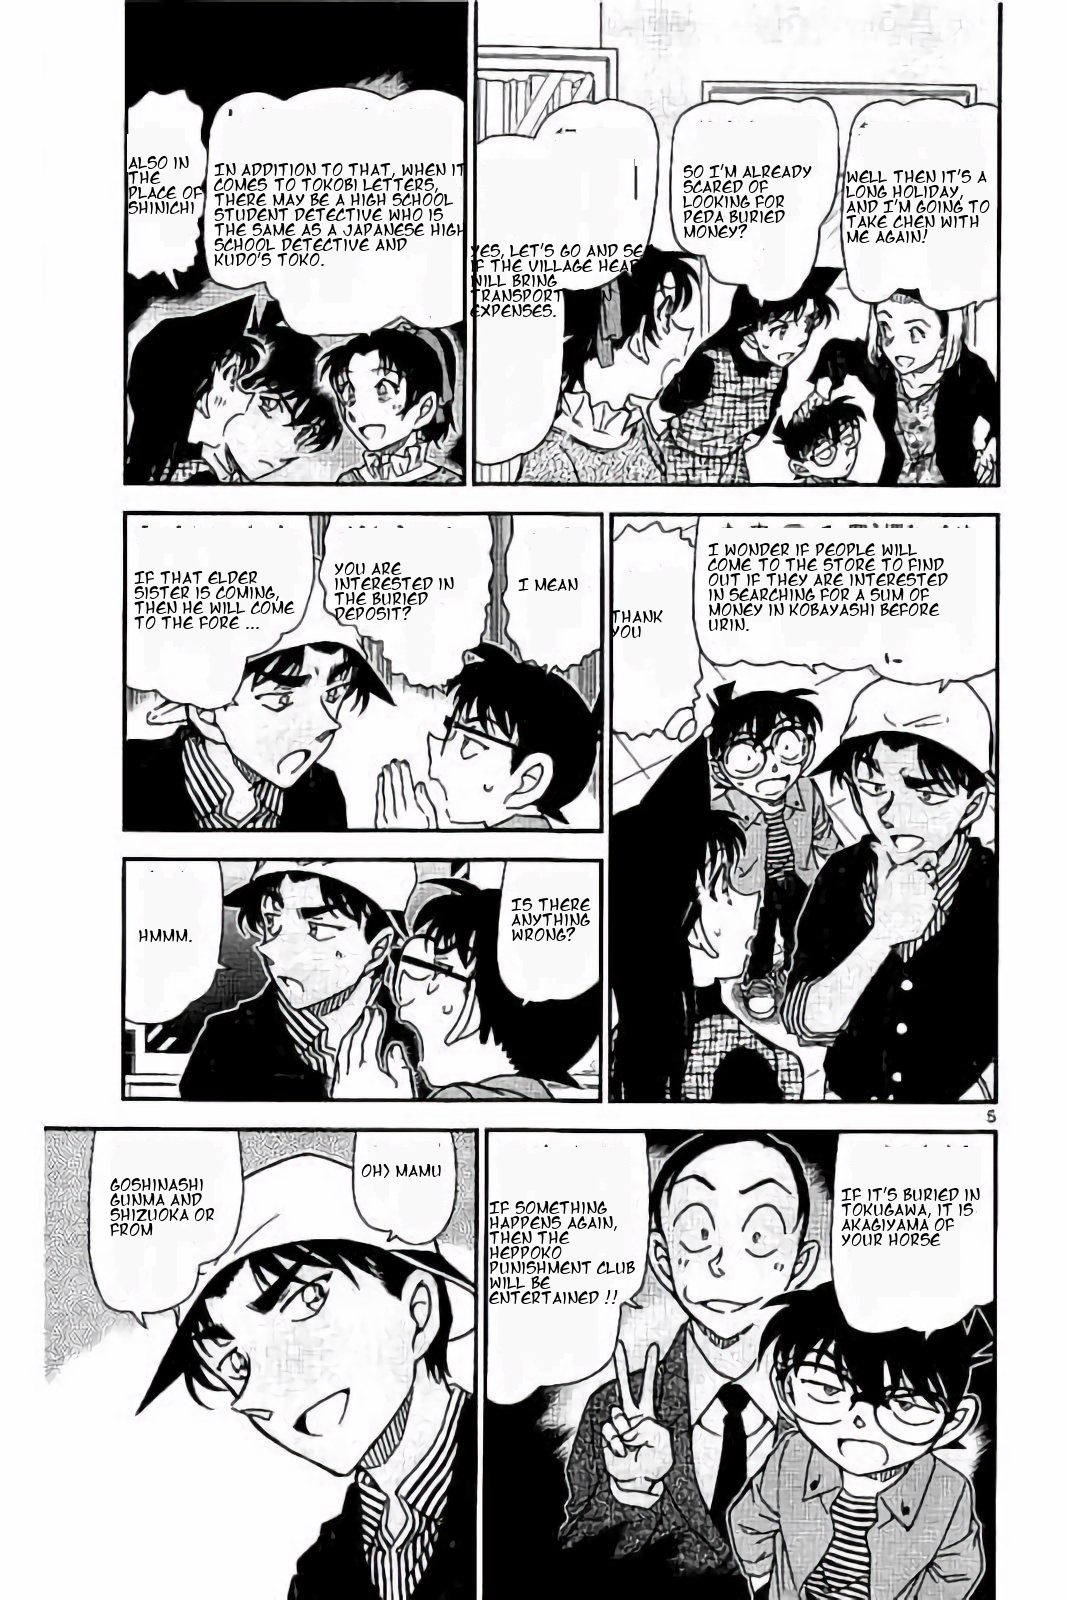

In [122]:
masked_im 

In [123]:
def demo_mark(masked_im):
    # Open the original image
    main = masked_im

    # Create a new image for the watermark with an alpha layer (RGBA)
    #  the same size as the original image
    watermark = Image.new("RGB", main.size)
    # Get an ImageDraw object so we can draw on the image
    waterdraw = ImageDraw.ImageDraw(watermark, "RGB")
    # Place the text at (10, 10) in the upper left corner. Text will be white.

    width, height = masked_im.size
    
    if width < 400:
        fontsize = 32
    elif width < 600:
        fontsize = 48
    elif width < 800:
        fontsize = 64
    elif width < 1000:
        fontsize = 80
    elif width < 1200:
        fontsize = 100
    elif width < 1400:
        fontsize =128
    elif width < 1800:
        fontsize= 156
    elif width < 2200:
        fontsize = 192
    elif width < 2600:
        fontsize = 256
    elif width < 3100:
        fontsize = 300
    
    print(width, height, fontsize)
    
    font_path ="mangat.ttf"
    font = ImageFont.truetype(font_path, int(fontsize*2))
    text = "D  E  M  O"
    text_w,text_h = font.getsize(text)
    
    waterdraw.text([(width-text_w)/2,(height-text_h)/2], text, fill=(128,128,128,128), font=font)
    textRotate = watermark.rotate(30)
    
    
    rLen = math.sqrt((text_w/2)**2+(text_h/2)**2)   
    oriAngle = math.atan(text_h/text_w)
    cropW = rLen*math.cos(oriAngle + math.pi/6) *2   #被截取区域的宽高
    cropH = rLen*math.sin(oriAngle + math.pi/6) *2
    box = [int((width-cropW)/2-1)-50,int((height-cropH)/2-1)-50,int((width+cropW)/2+1)+50,int((height+cropH)/2+1)]
    textIm = textRotate.crop(box)
#     return textIm
    
    pasteW,pasteH = textIm.size
    textBlank = Image.new("RGB",(width,height))
    pasteBox = (int((width-pasteW)/2-1),int((height-pasteH)/2-1))
    textBlank.paste(textIm,pasteBox)
    
    watermask = textBlank.convert("L").point(lambda x: min(x, 100))
#     return watermask
#     # Apply this mask to the watermark image, using the alpha filter to 
#     #  make it transparent
    watermark.putalpha(watermask)
#     # Paste the watermark (with alpha layer) onto the original image and save it
    main.paste(watermark, None, watermark)
    return main

1066 1600 100


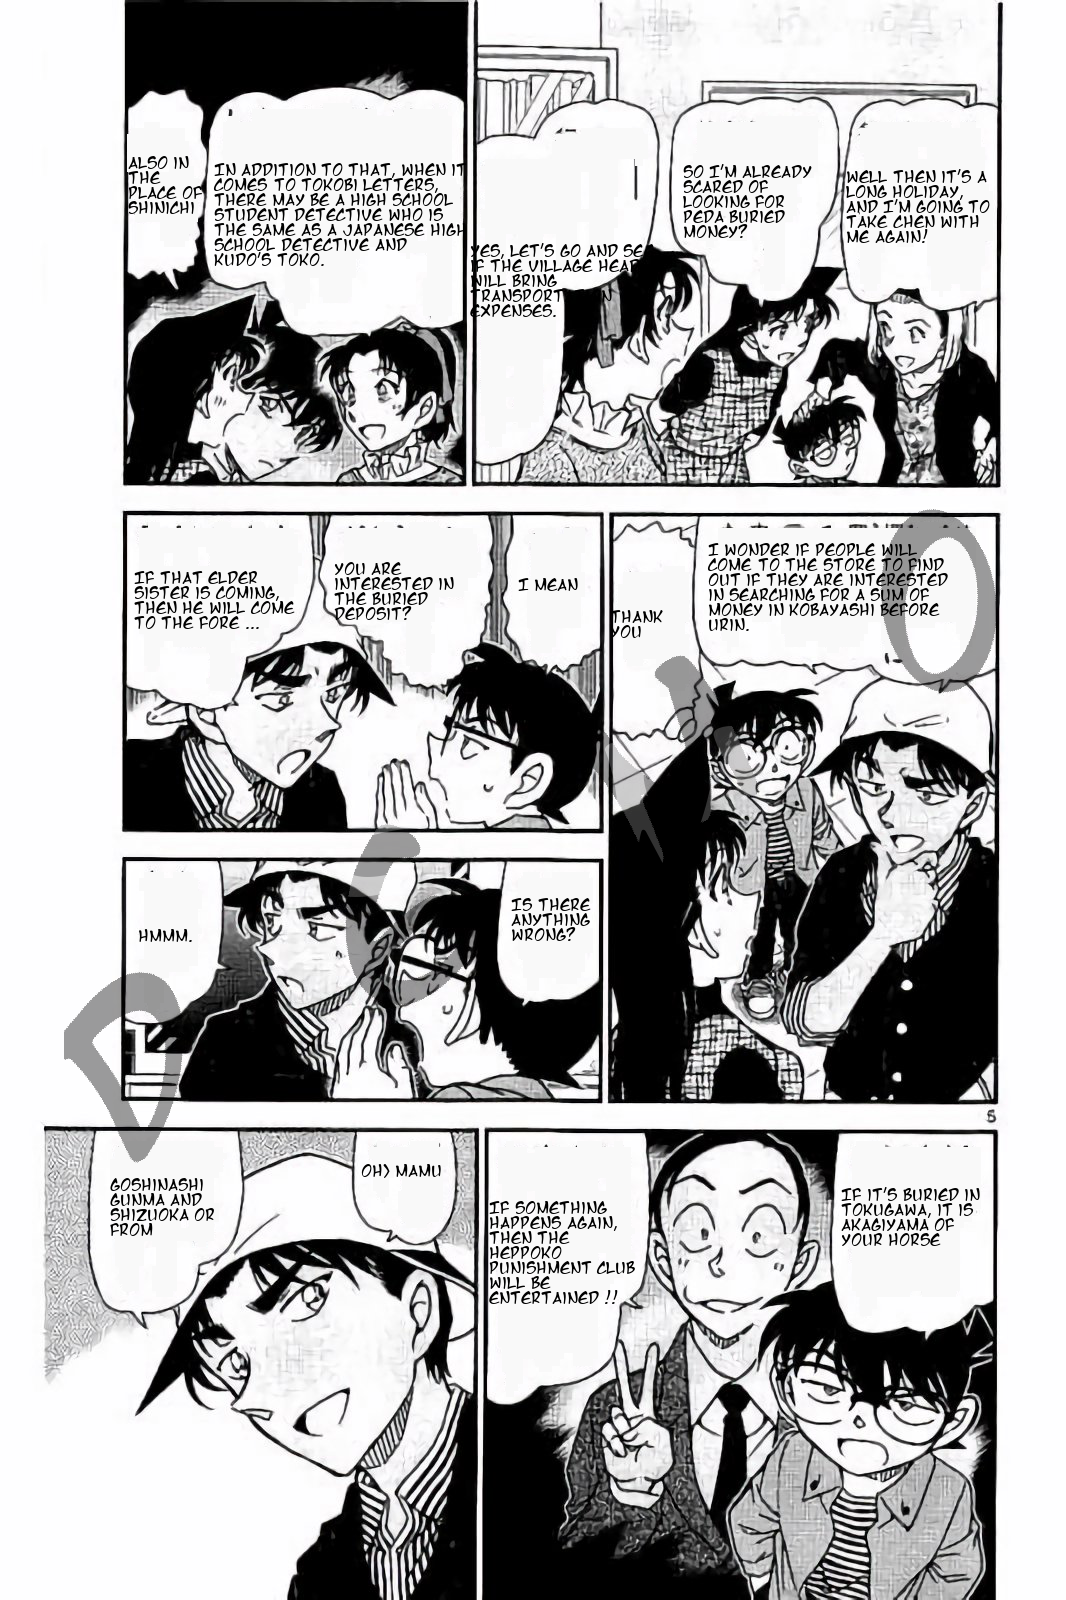

In [124]:
demo_mark(masked_im)

In [15]:
masked_im.save(img_path[:-4]+'_tsl.jpg')